In [ ]:
import pandas as pd
import os
import tarfile
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Extract the dataset
with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
    tar.extractall()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-2-ec5c148d407b>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Training Loss: 0.38005482957269965
Training Accuracy: 0.8261111111111111
Validation Loss: 0.2633632044825289
Validation Accuracy: 0.892
Epoch 2/3
Training Loss: 0.20487655055763773
Training Accuracy: 0.92
Validation Loss: 0.26397703038085074
Validation Accuracy: 0.894
Epoch 3/3
Training Loss: 0.0987009773283972
Training Accuracy: 0.9680000000000001
Validation Loss: 0.3780504465842294
Validation Accuracy: 0.881
Test Accuracy: 0.8751
Test Precision: 0.839579938439254
Test Recall: 0.9274
Test F1 Score: 0.8813076118977479


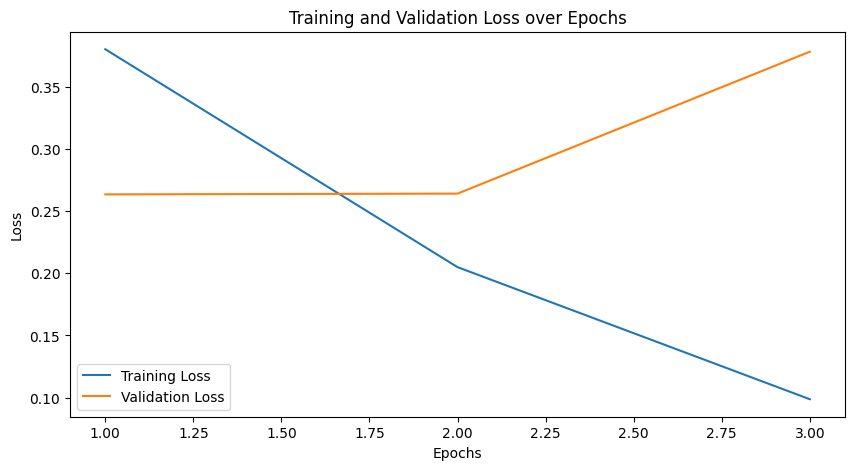

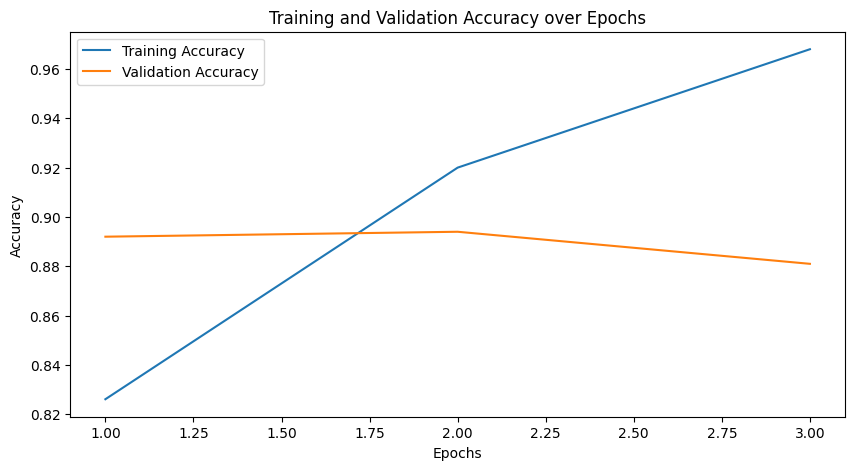

In [ ]:


# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Clean text function
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

# Load data from folder function
def load_data_from_folder(folder, sample_fraction=0.1):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        labeled_folder = os.path.join(folder, label)
        files = os.listdir(labeled_folder)
        sampled_files = pd.Series(files).sample(frac=sample_fraction, random_state=42).tolist()
        for file in sampled_files:
            with open(os.path.join(labeled_folder, file), 'r', encoding='utf-8') as f:
                text = f.read()
                cleaned_text = clean_text(text)
                data.append(cleaned_text)
                labels.append(1 if label == 'pos' else 0)
    return pd.DataFrame({'review': data, 'label': labels})

# Load the training and testing data with 40% sampling
train_df = load_data_from_folder('aclImdb/train', sample_fraction=0.1)
test_df = load_data_from_folder('aclImdb/test', sample_fraction=0.1)

# Further split the training data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Data preprocessing and Dataset class
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        review = str(self.dataframe.iloc[idx, 0])
        label = int(self.dataframe.iloc[idx, 1])
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # num_labels=2 for binary classification

# Prepare dataset and dataloaders
max_len = 512
batch_size = 16

train_dataset = IMDBDataset(train_df, tokenizer, max_len)
val_dataset = IMDBDataset(val_df, tokenizer, max_len)
test_dataset = IMDBDataset(test_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training configuration
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    average_train_loss = total_loss / len(train_loader)
    train_losses.append(average_train_loss)
    train_accuracy = correct_predictions.double() / len(train_loader.dataset)
    train_accuracies.append(train_accuracy.cpu().numpy())

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {average_train_loss}')
    print(f'Training Accuracy: {train_accuracy}')

    # Evaluation on validation set
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = correct_predictions.double() / len(val_loader.dataset)
    val_accuracies.append(val_accuracy.cpu().numpy())

    print(f'Validation Loss: {average_val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')

# Evaluation on test set
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate metrics on test set
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1 Score: {f1}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()


Plotting the validation metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-4-c183c846e1be>:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training Loss: 0.5150526693855043
Training Accuracy: 0.7354444444444445
Validation Loss: 0.36001495366531705
Validation Accuracy: 0.851
Epoch 2/5
Training Loss: 0.3469209994187787
Training Accuracy: 0.8557777777777779
Validation Loss: 0.3525351204332851
Validation Accuracy: 0.848
Epoch 3/5
Training Loss: 0.30014940064076207
Training Accuracy: 0.8788888888888889
Validation Loss: 0.3359878429817775
Validation Accuracy: 0.866
Epoch 4/5
Training Loss: 0.253058345333324
Training Accuracy: 0.8986666666666667
Validation Loss: 0.3537532579863355
Validation Accuracy: 0.864
Epoch 5/5
Training Loss: 0.21069558788931286
Training Accuracy: 0.9202222222222223
Validation Loss: 0.35407263407158474
Validation Accuracy: 0.867
Early stopping triggered
Test Accuracy: 0.8661
Test Precision: 0.890381744508424
Test Recall: 0.835
Test F1 Score: 0.8618020435545465


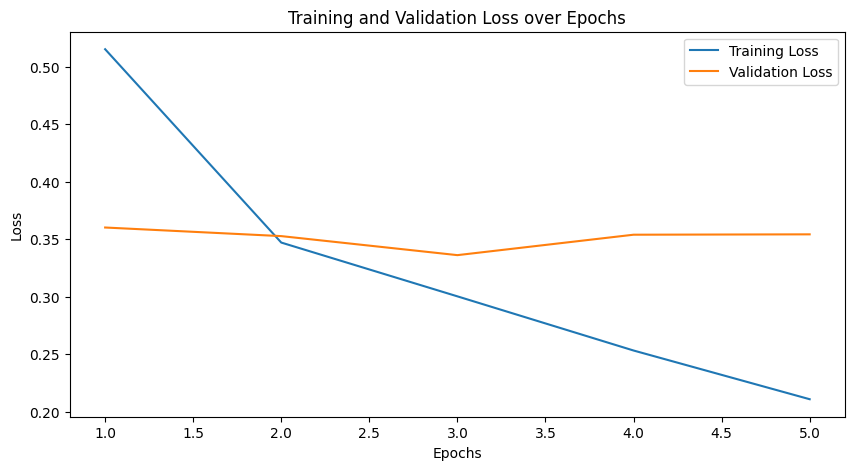

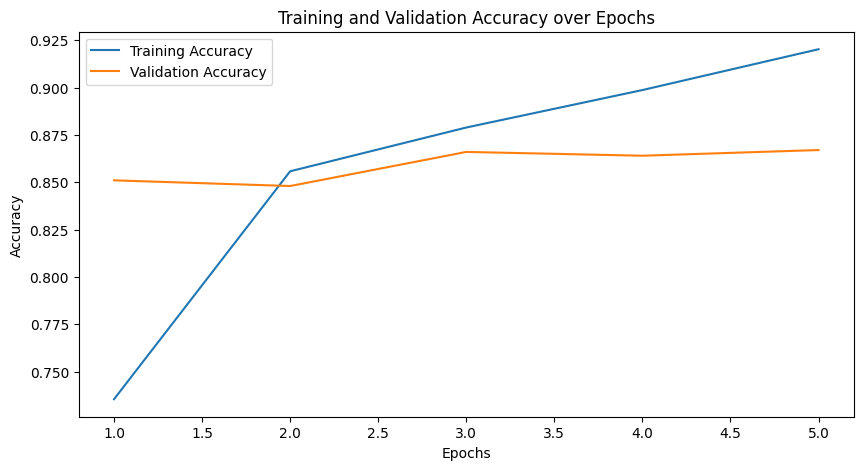

In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from bs4 import BeautifulSoup
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Clean text function
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

# Load data from folder function
def load_data_from_folder(folder, sample_fraction=0.4):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        labeled_folder = os.path.join(folder, label)
        files = os.listdir(labeled_folder)
        sampled_files = pd.Series(files).sample(frac=sample_fraction, random_state=42).tolist()
        for file in sampled_files:
            with open(os.path.join(labeled_folder, file), 'r', encoding='utf-8') as f:
                text = f.read()
                cleaned_text = clean_text(text)
                data.append(cleaned_text)
                labels.append(1 if label == 'pos' else 0)
    return pd.DataFrame({'review': data, 'label': labels})

# Load the training and testing data with 40% sampling
train_df = load_data_from_folder('aclImdb/train', sample_fraction=0.4)
test_df = load_data_from_folder('aclImdb/test', sample_fraction=0.4)

# Further split the training data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Data preprocessing and Dataset class
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        review = str(self.dataframe.iloc[idx, 0])
        label = int(self.dataframe.iloc[idx, 1])
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class BERTClassifier(nn.Module):
    def __init__(self, bert_model):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.4)  # Increased dropout
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = BERTClassifier(bert_model.bert)

# Prepare dataset and dataloaders
max_len = 128  # Reduced max_len to 128
batch_size = 16

train_dataset = IMDBDataset(train_df, tokenizer, max_len)
val_dataset = IMDBDataset(val_df, tokenizer, max_len)
test_dataset = IMDBDataset(test_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training configuration
optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=0.01)  # Further reduced learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
patience = 2
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    average_train_loss = total_loss / len(train_loader)
    train_losses.append(average_train_loss)
    train_accuracy = correct_predictions.double() / len(train_loader.dataset)
    train_accuracies.append(train_accuracy.cpu().numpy())

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {average_train_loss}')
    print(f'Training Accuracy: {train_accuracy}')

    # Evaluation on validation set
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = correct_predictions.double() / len(val_loader.dataset)
    val_accuracies.append(val_accuracy.cpu().numpy())

    print(f'Validation Loss: {average_val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')

    # Early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Evaluation on test set
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1).flatten()
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate metrics on test set
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1 Score: {f1}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()


## The baseline model used here is Logistic Regression

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


X_train, X_val, y_train, y_val = train_test_split(train_df['review'], train_df['label'], test_size=0.1, random_state=42)
X_test = test_df['review']
y_test = test_df['label']


baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('lr', LogisticRegression(max_iter=1000))
])


baseline_model.fit(X_train, y_train)


baseline_val_predictions = baseline_model.predict(X_val)
baseline_test_predictions = baseline_model.predict(X_test)

baseline_val_accuracy = accuracy_score(y_val, baseline_val_predictions)
baseline_val_precision = precision_score(y_val, baseline_val_predictions)
baseline_val_recall = recall_score(y_val, baseline_val_predictions)
baseline_val_f1 = f1_score(y_val, baseline_val_predictions)

baseline_test_accuracy = accuracy_score(y_test, baseline_test_predictions)
baseline_test_precision = precision_score(y_test, baseline_test_predictions)
baseline_test_recall = recall_score(y_test, baseline_test_predictions)
baseline_test_f1 = f1_score(y_test, baseline_test_predictions)

print(f'Baseline Model - Validation Accuracy: {baseline_val_accuracy}')
print(f'Baseline Model - Validation Precision: {baseline_val_precision}')
print(f'Baseline Model - Validation Recall: {baseline_val_recall}')
print(f'Baseline Model - Validation F1 Score: {baseline_val_f1}')

print(f'Baseline Model - Test Accuracy: {baseline_test_accuracy}')
print(f'Baseline Model - Test Precision: {baseline_test_precision}')
print(f'Baseline Model - Test Recall: {baseline_test_recall}')
print(f'Baseline Model - Test F1 Score: {baseline_test_f1}')



NameError: name 'train_test_split' is not defined

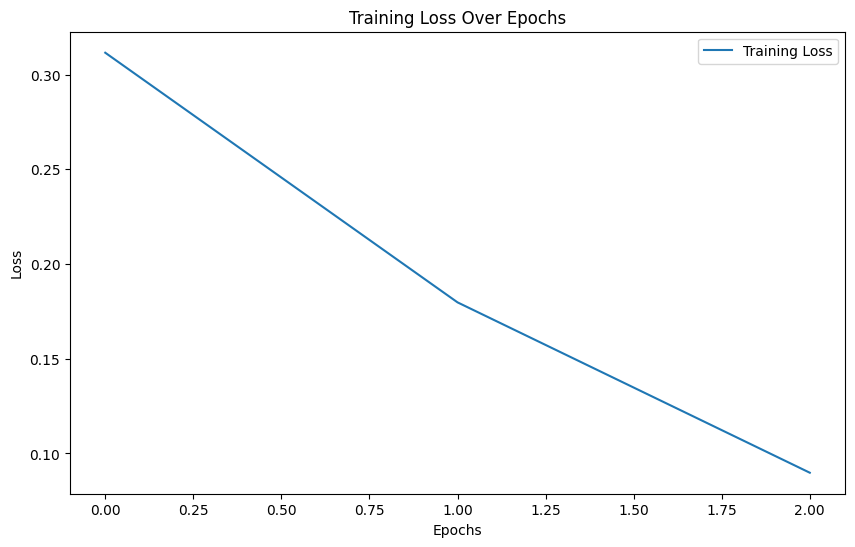

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()